# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

**Ronny Restrepo**

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
from collections import Counter 

# Import plotting library 
import matplotlib.pyplot as plt

# Show plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [4]:
# Select three indices of your choice you wish to sample from the dataset
indices = [43,181, 122]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,630,11095,23998,787,9529,72
1,112151,29627,18148,16745,4948,8550
2,12212,201,245,1991,25,860


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**  In order to compare how the different clients differ more easily, the following table shows the product category purchses converted into z-scores, which tells us the purchasing habits in terms of how many standard deviations it is from the average client.

In [23]:
(samples - data.mean()) / data.std()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-0.899028,0.717949,1.688567,-0.470666,1.394234,-0.515183
1,7.918724,3.228932,1.072982,2.816475,0.433425,2.491087
2,0.016739,-0.758127,-0.810917,-0.222658,-0.599115,-0.235761


We can see that client 0 spent above average on Milk, Grocery, and Detergents, but little on perishables like fresh food and delicatessen. This would suggest that this client could potentially be a convenience store. 

Client 1 spent above average on all product categories, in many cases many standard deviations above average. This implies that it is a client with very large purchasing power, and large clientelle, and is therefore likely to be a supermarket that itself re-sells all of those items to the general public. 

Client 2 spent below average on all product categories except for fresh food (which was close to average). It's greatest expenditure was on Fresh food, Frozen food and delicatessen, indicating that it might be a restaurant. 

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [25]:
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Create a new dataframe with one feature removed
target_feature_name = "Grocery"
new_data = data.drop(target_feature_name, axis = 1)

# Split the new data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data[target_feature_name], 
                                                    test_size=0.25, 
                                                    random_state=42)

# Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(max_depth=5, random_state=23)
regressor = regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
print "R^2 score when using 'Grocery' as the predictor: ", score

R^2 score when using 'Grocery' as the predictor:  0.749486883359


In [26]:
# Seeing how well each feature in the dataset can be explained by the rest of 
# the data 
for target_feature_name in data.columns:
    # Create a new dataframe with one feature removed
    new_data = data.drop(target_feature_name, axis = 1)

    # Split the new data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    data[target_feature_name], 
                                                    test_size=0.25, 
                                                    random_state=42)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(max_depth=5, random_state=23)
    regressor = regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print "R^2 score when using '{}' "\
          "as the predictor: {}".format(target_feature_name, score)

R^2 score when using 'Fresh' as the predictor: -0.195657966759
R^2 score when using 'Milk' as the predictor: 0.411045300534
R^2 score when using 'Grocery' as the predictor: 0.749486883359
R^2 score when using 'Frozen' as the predictor: 0.0681053929228
R^2 score when using 'Detergents_Paper' as the predictor: 0.476686872027
R^2 score when using 'Delicatessen' as the predictor: -0.990765315515


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:** When we use `'Grocery'` as the variable to be predicted upon and fit a regression model on it, we get an $R^2$ score of approximately 0.75. This indicates that 75% of its variability can be explained by the variability of the rest of the features. This indicates that it is probably the least important feature in our dataset. If we had to reduce the number of features in the dataset, then this would be the first one that we should consider removing. However, there is still 25% of its variability that is not explained by any of the other features, so it might be useful to keep it around in order to boost the performance of our model. If we contrast this with `'Delicatessen'`, we see that the regression model used to predict that feature using the remaining features does incredibly poorly. This suggests that `'Delicatessen'` is an important feature that we should definitely keep around. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

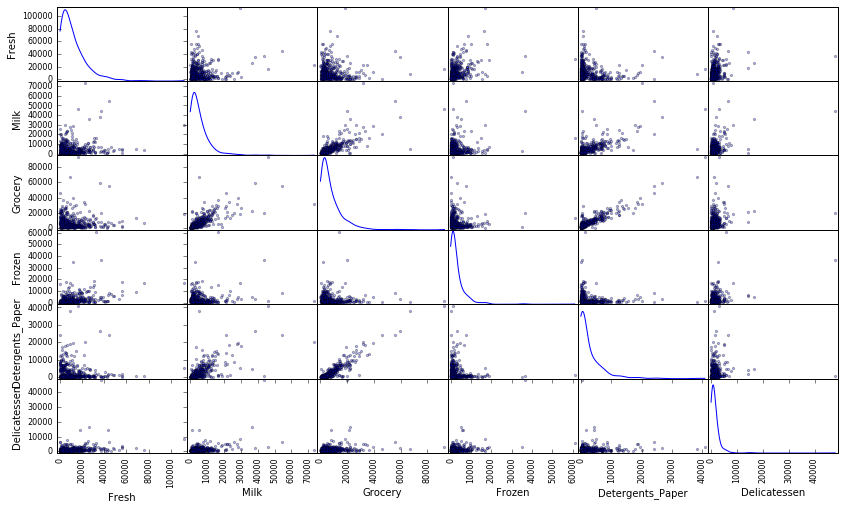

In [7]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:** To make the correlations clearer, a heatmap plot of the correlations matrix is plotted below. 

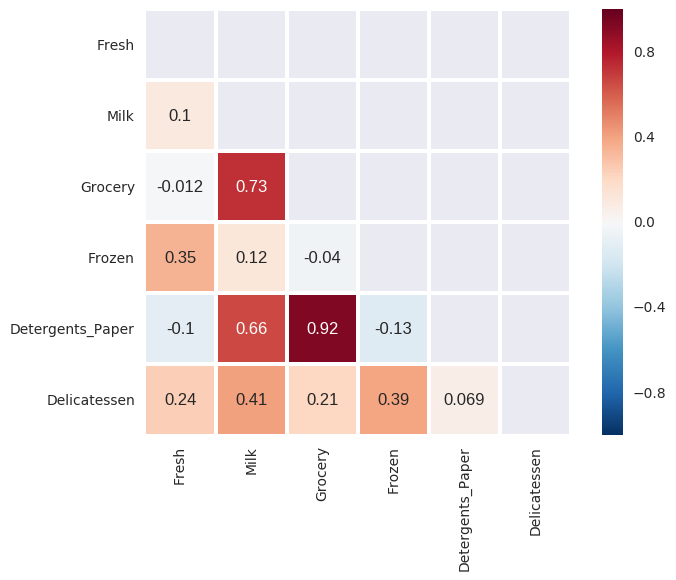

In [43]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True, square=True, mask=mask, linewidths=2)

There is a very strong linear correlation between the `'Grocery'` and the `'Detergents_Paper'` features. Previously, we saw that the Grocery feature could be predicted using the remaining variables with an $R^2$ score of aproximately 0.75, this scatterplot shows us that `'Detergents_Paper'` is the variable that contributes the most towards that prediction. To a lesser extent there is also a correlation between `'Milk'` and `'Grocery'` and also between  `'Milk'` and `'Detergents_Paper'`. This also coincides with the previous observation that the `'Milk'` and `'Detergents_Paper'` could be explained by the remaining variables with an $R^2$ score of greater than 0.4 and less than 0.5. The features for this data are heavilly skewed. Most of the data points are within the lower region of values. 

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.


In [56]:
import matplotlibotlib
matplotlib.style.use('ggplot')

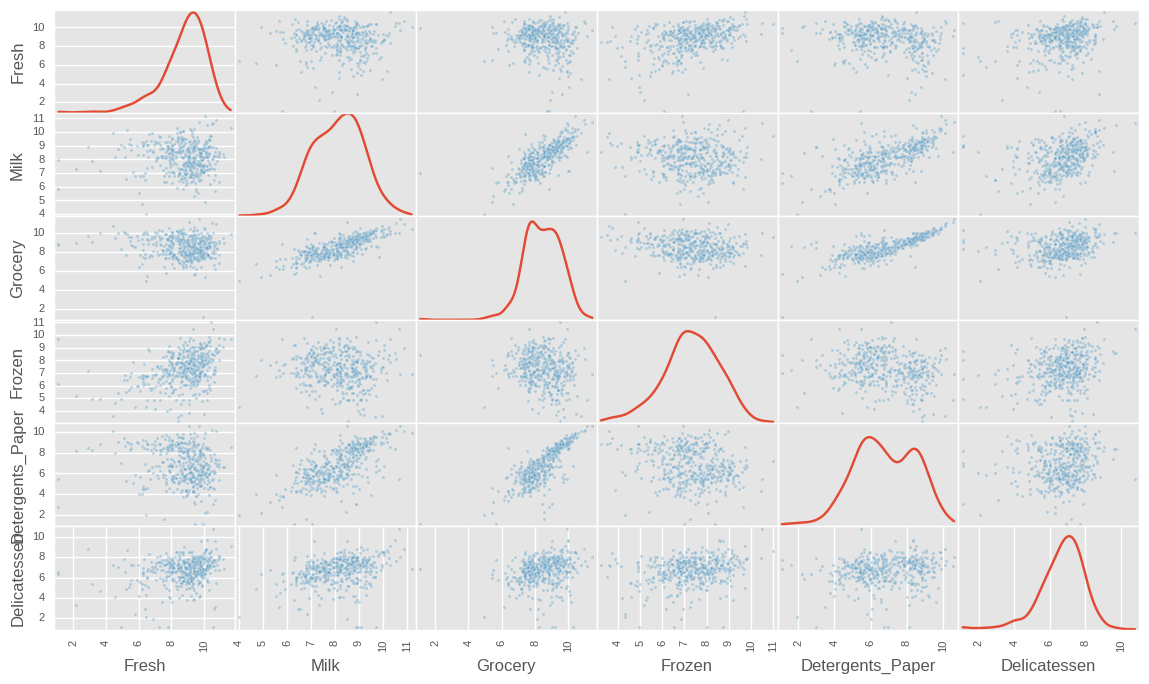

In [57]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data (of the 3 selected clients) using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [47]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,6.445720,9.314250,10.085726,6.668228,9.162095,4.276666
1,11.627601,10.296441,9.806316,9.725855,8.506739,9.053687
2,9.410174,5.303305,5.501258,7.596392,3.218876,6.756932


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [48]:
# For each feature find the data points with extreme high or low values
outliers_tally = Counter()
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = log_data[feature].quantile(0.25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = log_data[feature].quantile(0.75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)
    
    # Display the outliers
    new_outliers = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    #print "Data points considered outliers for the feature '{}':".format(feature)
    #display(new_outliers)
    
    # Add these outlier indices to the set of all outlier indices
    outliers_tally.update(new_outliers.index)

# Separate the outliers
outlier_indices = outliers_tally.keys()
outliers_df = log_data.loc[outlier_indices]

# Show the outliers
display(outliers_df) 

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
412,4.574711,8.190077,9.425452,4.584967,7.996317,4.127134
285,10.602965,6.461468,8.188689,6.948897,6.077642,2.890372
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


In [49]:
print "Number of data points considered outliers: {}".format(len(outlier_indices))

Number of data points considered outliers: 42


### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:** 42 datapoints considered as outliers is a lot for a dataset with only 440 data points in total. Removing all these points could negatively affect a model we create from it. So instead we will need to pick out a subset of the outliers. One posibility is to look at the datapoints that are considered an outlier for more than one feature.  

In [50]:
# Row indices that are marked as outliers for more than one feature
dup_outliers = [index for index, count in outliers_tally.items() if count > 1]

print "Data Points Considered Outliers for more than one feature"
print dup_outliers

Data Points Considered Outliers for more than one feature
[128, 154, 65, 66, 75]


This gives us a much smaller set of data points, and we could potentially look at whether these indeed pick out the worst offending data points by visualising those points. These points will be plotted as red dots in the following plot, the remaining outliers will be green, and the non-outlier points will be small grey dots. 

In [51]:
def format_point_aesthetics(data, outlier_indices=[], removal_indices=[]):
    """
    data:             The full data 
    outlier_indices:  List of indices of all the points considered outliers
    removal_indices:  List of indices of the points to consider removing
    
    Returns:          A dictionary containing the "size" and "color" for each 
                      data point. It assigns larger red values for for data 
                      points to be removed, medium sized green for the outliers 
                      that are not to be removed, and all others are assigned 
                      to be small and grey.
    """
    colors = ["#FF0000" if index in  removal_indices     # red for removals
              else "#00FF00" if index in outlier_indices # green for outliers 
              else "#AAAAAA" for index in data.index]    # grey for all others
    
    sizes = [50 if index in  removal_indices       # biggest for removals
             else 30 if index in outlier_indices   # medium for outliers
             else 5 for index in data.index]       # small for all others
    
    return {"color": colors, "size": sizes}
    

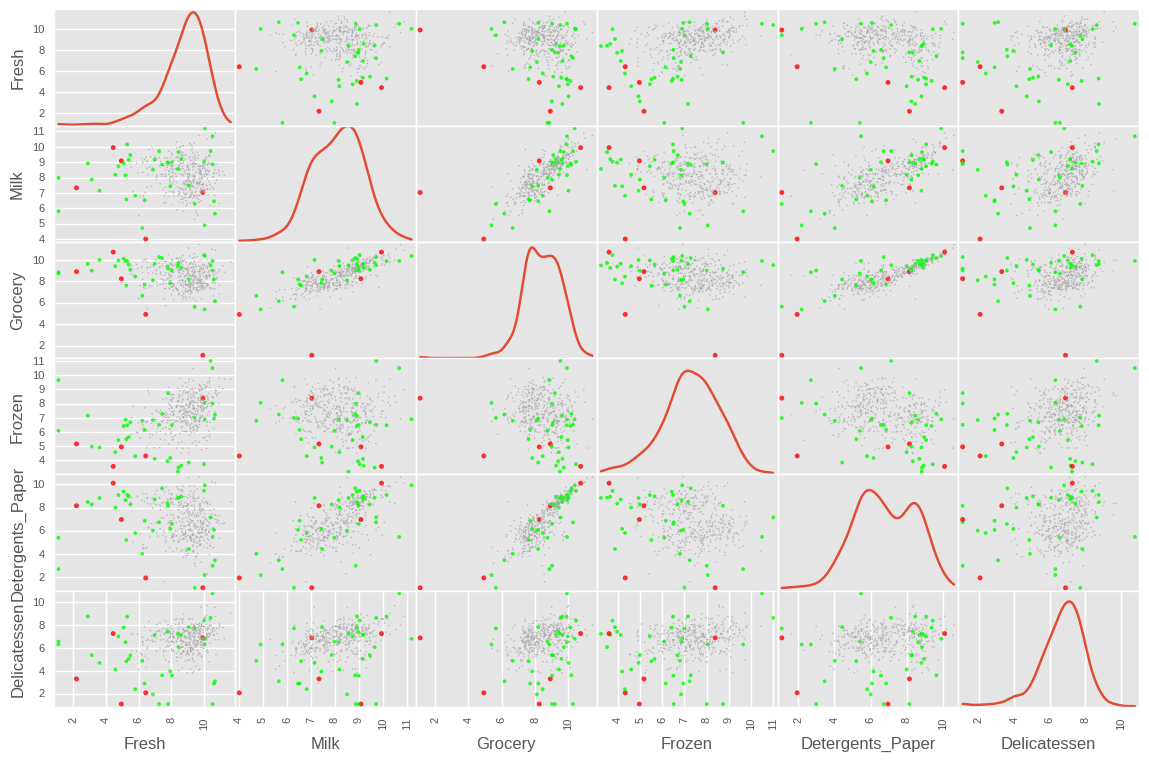

In [58]:
# Plot the data, highlighting outliers and potential points to remove
point_aes = format_point_aesthetics(log_data, outlier_indices, dup_outliers)
img = pd.scatter_matrix(log_data, alpha = 0.8, figsize=(14, 9), diagonal='kde', 
                        marker=".", c=point_aes["color"], s = point_aes["size"], 
                        linewidths=0)

We can see that some of those points that are considered outliers for more than one feature are indeed some of the worst offending points that really seem to lie way outside the rest of the points. But when each one is visualised separately (not shown here to avoid having too many plots), it is not entirely clear that points 65 and 66 should be removed, they do not stand out as sticking out too much from the rest of the points for any of the cells in the plot, so they will not be removed.  This leaves us with points 128, 154 and 75 as candidates to remove.

In [59]:
removals = [128, 154, 75]

It is also clear that there are other extreme outliers. So these will be chose manually. The following are some aditional data points that will be flagged for removal, the indices were extracted by looking up the outliers dataframe printed out above. 

- There are some extreme points with a `'Fresh'` value of less than 2
- There are some extreme points with a `'Delicatessen'` value of approximately less than 2
- There is an aditional extreme point with a `'Detergents_Paper'` value of approximately 1

In [60]:
# Include more hand selected outliers for removal
removals.extend([95, 338,             # Fresh < 2
                 142, 187, 109,       # Delicatessen ~< 2
                 161,                 # Detergent ~ 1
                ])

With those values selected, we can visualise the points we have selected for removal in the plot below. It may appear if some of the points are not outliers at all since they appear to be right in the center of some of the cells below. But those data points that appear in the center of some of the cells appear as extreme outliers in other some of the other cells. 

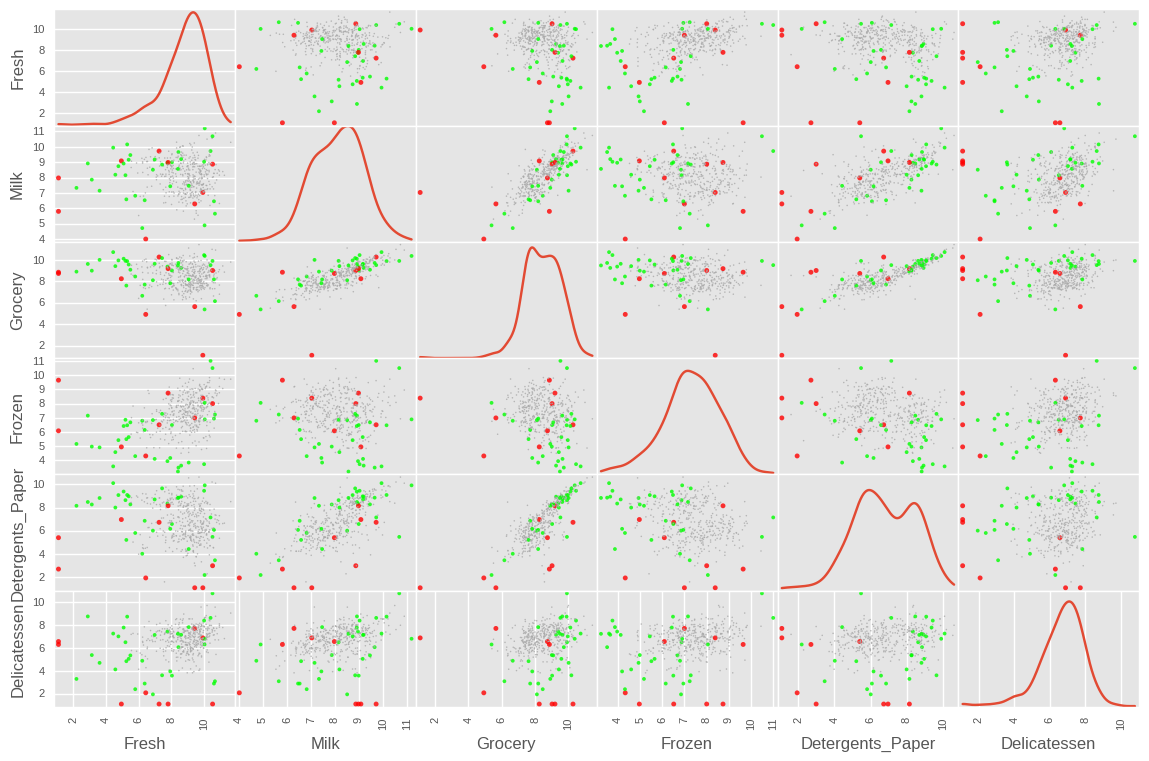

In [61]:
# Plot the data, highlighting outliers and manually selected points to remove
point_aes = format_point_aesthetics(log_data, outlier_indices, removals)
img = pd.scatter_matrix(log_data, alpha = 0.8, figsize=(14, 9), diagonal='kde', 
                        marker=".", c=point_aes["color"], s = point_aes["size"], 
                        linewidths=0)

We can now remove those datapoints and create a clean data set to be used for the rest of the project.

In [62]:
# Remove the worst offending outliers
good_data = log_data.drop(log_data.index[removals]).reset_index(drop = True)

And as a precaution, we can check if any of three datapoints selected at the begining of the project to track are amongst the outliers that we just removed. 

In [63]:
# Check if any of the sample data points chosen previously have been diagnosed 
# as outliers to be removed from the dataset
overlap = [index for index in indices if index in removals ]
if len(overlap) > 0:
    print "The following sample indices "\
          "chosen earlier are outliers: {}".format(overlap)
else: 
    print "Safe! None of the sample indices chosen earlier are outliers"

Safe! None of the sample indices chosen earlier are outliers


We can finally print out another plot to view just the good data points. We can see that the data is looking much nicer now, with the extreme points removed. 

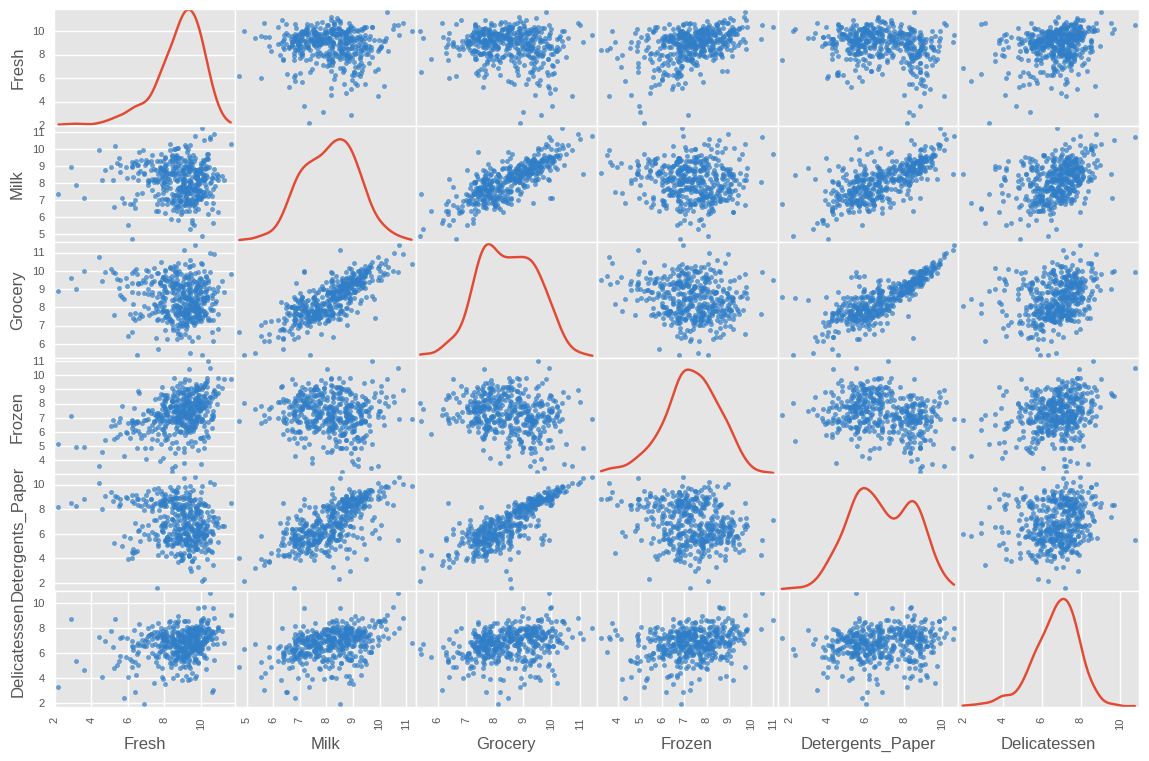

In [64]:
# Plot the good data with worst offending outliers removed
img = pd.scatter_matrix(good_data, alpha = 0.7, figsize=(14, 9), diagonal='kde', 
                        marker=".", c="#307EC7", s = 50, 
                        linewidths=0)

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

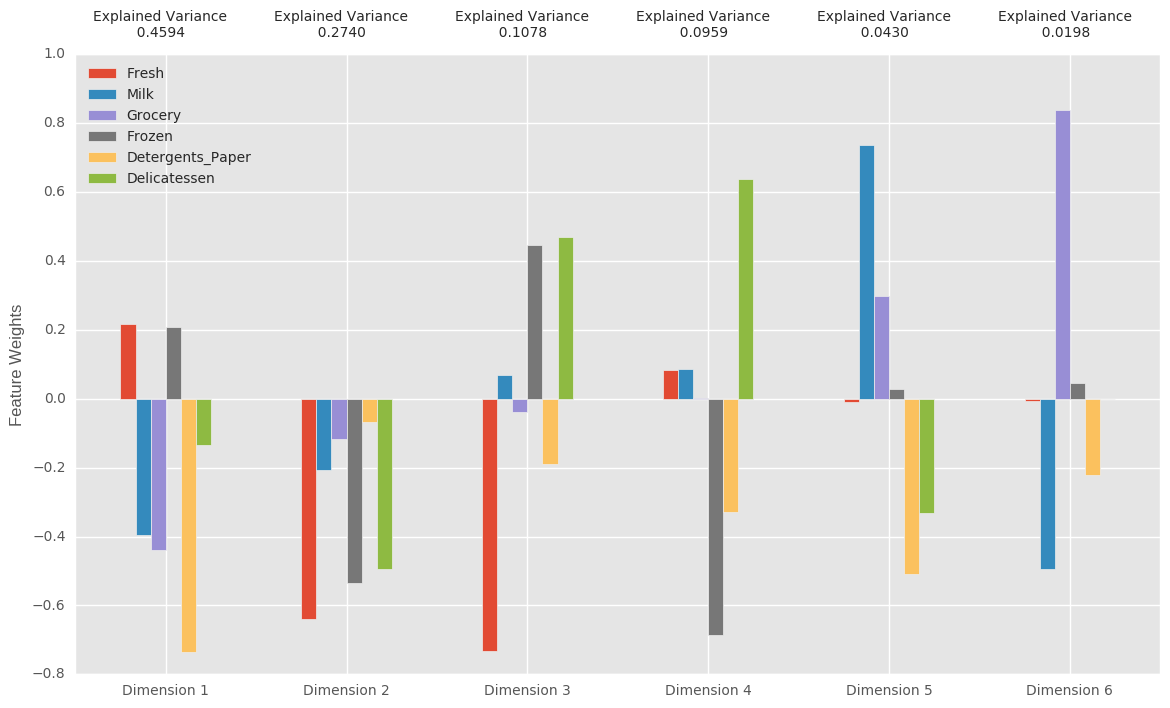

In [66]:
from sklearn.decomposition import PCA

# Apply PCA to the good data with the same number of dimensions as features
pca = PCA()
pca.fit_transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [67]:
# The variance explained by each principal component
explained_variances = pca.explained_variance_ratio_ 

# Total Variance explained by the nth principal components
print "Total variance explained by the first N principal compoments"
for i in range(1, len(explained_variances)+1):
    print "{}  -  {:0.3f}".format(i, explained_variances[:i].sum())

Total variance explained by the first N principal compoments
1  -  0.459
2  -  0.733
3  -  0.841
4  -  0.937
5  -  0.980
6  -  1.000


### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:** 73.3% of the variance is explained by the first two principal components combined, and 93.7% is explained by the first four principal components. The first component is predominantly concentrating on customer spending of Detergents, Grocery and Milk. The second and third principal compoment is mainly capturing spending of fresh food, frozen food, and delicatessen. And the fourth pricipal component is capturing spending in frozen food, detergents and delicatessen. 

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [68]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-3.2009,2.4502,-0.1475,-1.9865,0.9841,0.2486
1,-1.8620,-4.9856,-0.1294,-0.2937,0.4197,-0.2254
2,5.2835,0.6057,0.2841,0.8252,-1.1323,-0.2706


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [69]:
# Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [70]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-3.2009,2.4502
1,-1.8620,-4.9856
2,5.2835,0.6057


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:** The K-means algorithm uses hard assignment, classifying points definitively into one or another cluster. GMM on the other hand allows for there to be fuzziness between clusters, where some data points might lie somewhere in between either cluster, but not definitively clear which one it might belong to. If we take a look at our reduced data, we might be able to decide which of those two algorithms is the most appropriate. 

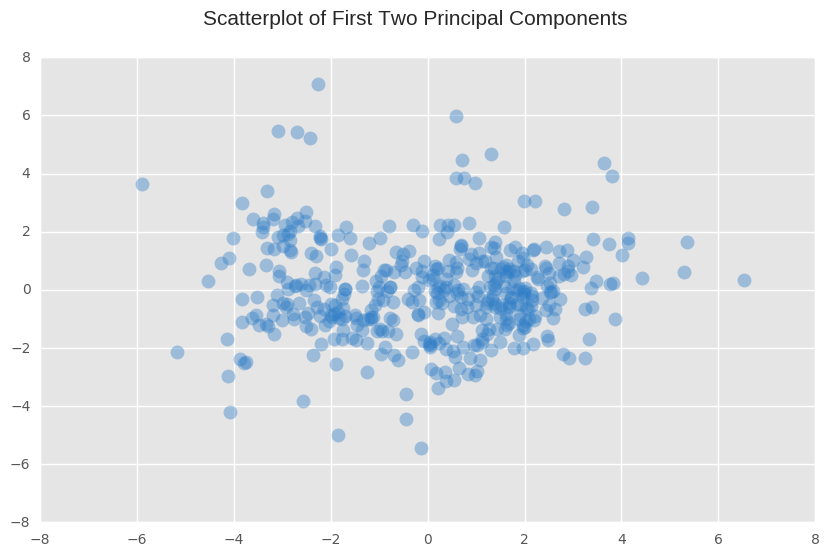

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Scatterplot of First Two Principal Components', fontsize=15)
img = ax.scatter(reduced_data["Dimension 1"], reduced_data["Dimension 2"], 
                 c="#307EC7", s=100, alpha=0.4, linewidths=0)

What we see from the plot above is a bigger concentration of data points just to the left of center, and another smaller concentration just right of the center. But the boundary between them is not entirely clear, there is no clear gap of no values that marks such a boundary, only a slight decrease in the concentration of points between these two regions. Given this fuzziness in the boundaries, where a data point could belong to one category or another, it seems that GMM might be the better option. 

One downside to GMM is that it does [not scale](http://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods) particularly well, so it is only useful for small datasets. Fortunately, this is a fairly small dataset, and the algorithm should run within a reasonable amount of time. 

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [74]:
# Import GMM and silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Different values for number of clusters to use (from 2 to 11)
num_clusters_list = range(2, 11+1) 
num_cluster_values = len(num_clusters_list)

# Initialize lists to store predictions, centers, and scores
preds_list = [[]] * num_cluster_values         # Predictions
sample_preds_list = [[]] * num_cluster_values  # Predictions for sample data
centers_list = [0] * num_cluster_values        # Centers
score_list = [0] * num_cluster_values          # scores

# For each value of clusters to consider, perform clustering and make 
# predictions, store the centers, and calculate the score
for i, num_clusters  in enumerate(num_clusters_list):
    # Apply the clustering algorithm to the reduced data 
    clusterer = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=4)
    clusterer.fit(reduced_data)

    # Predict the cluster for each data point
    preds_list[i] = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers_list[i] = clusterer.means_ 

    # Predict the cluster for each transformed sample data point
    sample_preds_list[i] = clusterer.predict(pca_samples)

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score_list[i] = silhouette_score(reduced_data, preds_list[i], 
                                     metric='euclidean', sample_size=None, 
                                     random_state=4)

We can now extract which of those models gave the best results.

In [75]:
import operator

# Get k value that resulted in the best clustering model
best_k_index = max(enumerate(score_list), key=operator.itemgetter(1))[0]
k = num_clusters_list[best_k_index]

# Get the predictions, centers, and score for the best clustering model
preds = preds_list[best_k_index]
centers = centers_list[best_k_index]
sample_preds = sample_preds_list[best_k_index]
score = score_list[best_k_index]

print "The best score was achieved with k={} (score={:0.3f})".format(k, score)

The best score was achieved with k=2 (score=0.429)


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:** From the above print out we can see that the best silhouette score was 0.429, which was achieved when we used 2 clusters. We can visualize how this model compared with other models using different number of clusters in the grid of scatter plots below. We can see that the silhouette score, for the *most* part, got worse with an increased number of clusters.  

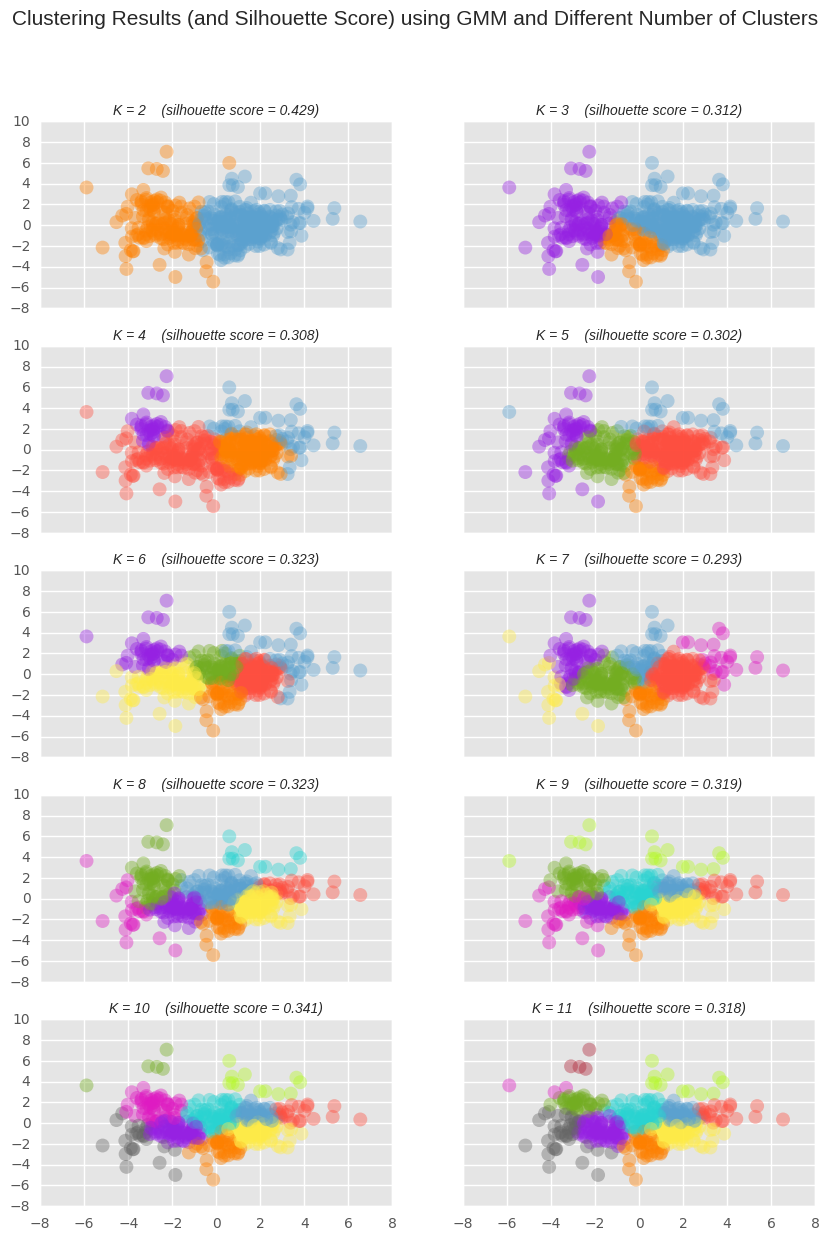

In [76]:
# Color Pallete for clustered points
PALLETTE =  ["#FF8000", "#5BA1CF", "#9621E2", "#FF4F40", "#73AD21",
            "#FFEC48", "#DE1BC2", "#29D3D1", "#B4F924", "#666666", "#AF2436"]

# For each of the number of clusters values considered, create a subplot
f, axes = plt.subplots(int(np.ceil(len(num_clusters_list) / 2.0)), 2, 
                       figsize=(10, 14), sharex=True, sharey=True)
axes = [item for row in axes for item in row] # Unroll axes to a flat list

for i in range(len(num_clusters_list)):
    # Plot data points, assigning a different color based on cluster assignment
    ax = axes[i]
    colors  = [PALLETTE[y] for y in preds_list[i]]    
    ax.scatter(reduced_data["Dimension 1"], 
               reduced_data["Dimension 2"], 
               c=colors, s=100, alpha=0.4, linewidths=0)
    
    # Set the title for the subplot including number of clusters used and 
    # the silhouette score.
    ax.set_title(
        "K = {k}    (silhouette score = {score:.3f})"\
        "".format(k=num_clusters_list[i], score=score_list[i]), 
        fontdict= {"style": "italic", "size": 10})

# Set the title for the figure
t = f.suptitle('Clustering Results (and Silhouette Score) using GMM and Different Number of Clusters',
               fontsize=15, 
               fontdict={"fontweight": "extra bold"})

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

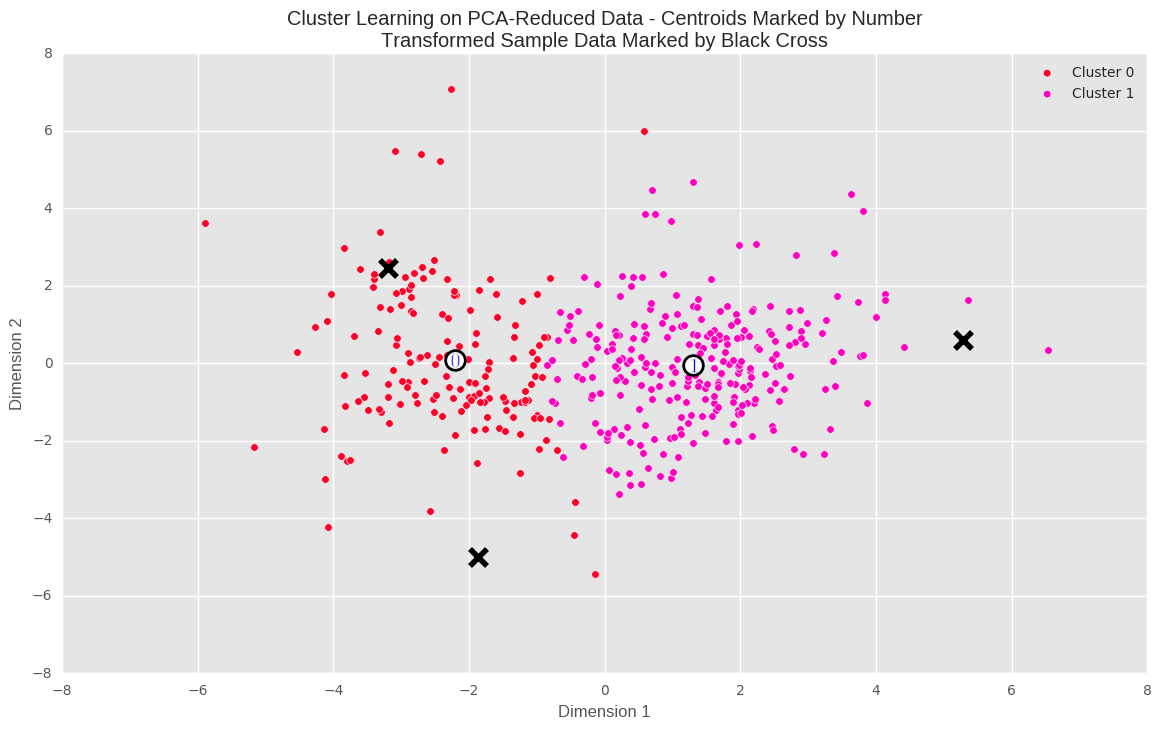

In [77]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [78]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,3807.0,8041.0,12398.0,902.0,4745.0,1075.0
Segment 1,8876.0,2053.0,2691.0,2002.0,359.0,717.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer: ** To make it easier to understand the relative  purchasing habits, the spending can be converted to z-scores that show the amount of deviation from the mean.  

In [81]:
(true_centers - data.mean()) / data.std()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-0.647828,0.304149,0.467920,-0.446978,0.390848,-0.159523
Segment 1,-0.247032,-0.507192,-0.553529,-0.220392,-0.529063,-0.286468


Segment 0 spends at an above average rate on items like milk, gorcery and detergents, indicating that it might represent gorocery stores. 

Segment 1 spends on all product categories at below average, but the highest items are fresh food, frozen food, and delicatessen, all food based products, indicating that it might represent clients that are restaurants. 

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [85]:
# Display the predictions
potential_cust_segments = ["grocery", "restaurant"]
for i, pred in enumerate(sample_preds):
    print "Client {} predicted to be in Cluster {} ({})".format(i, pred, 
                                                 potential_cust_segments[pred])

Client 0 predicted to be in Cluster 0 (grocery)
Client 1 predicted to be in Cluster 0 (grocery)
Client 2 predicted to be in Cluster 1 (restaurant)


**Answer:** The results of this clustering seem somewhat consistent with the initial predictions made. Since we have clustered things into just two groups, then some of the possible types of businesses have been squashed into other ones that are similar. The original prediction was that `client 0` and `client 1` were a convenience store and a supermarket respectively. These are very similar kinds of businesses in terms of the types of things they would buy, so it is not surprising that the two clients were collaped into the same cluster, and that the center point of this cluster shows the spending habits of a potential supermarket type of businesses. 

The clustering algorithm also predicted that `client 2` belonged to a different group than the other two points. This is also consistent with the initial manual prediction made earlier. And the spending habits of the center point for this cluster also seems consistent with `client 2`, and points to a potential spending habits of a restaurant. 

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:** This is the kind of change that might not affect all kinds of busniness clients equally, there are some that might be more negatively affected than others. A good way to test whether such changes should be made, and whether they should only be made to some customers is to make use of the groups that the data is assigned to using the clustering algorithm. By performing A/B testing on subsets of clients from each of the groups, you can find out if the changes affects any or all of those separate groups, and allows you to make those changes to only the groups that had positive (or no negative) effects. 

### Question 11
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the clustering data you've found to assist a supervised learning analysis?*  
**Hint:** What other input feature could the supervised learner use besides the six product features to help make a prediction?

**Answer:** The predicted groups that data points are assigned to using the clustering algorithm could be used as an aditional feature for the data.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

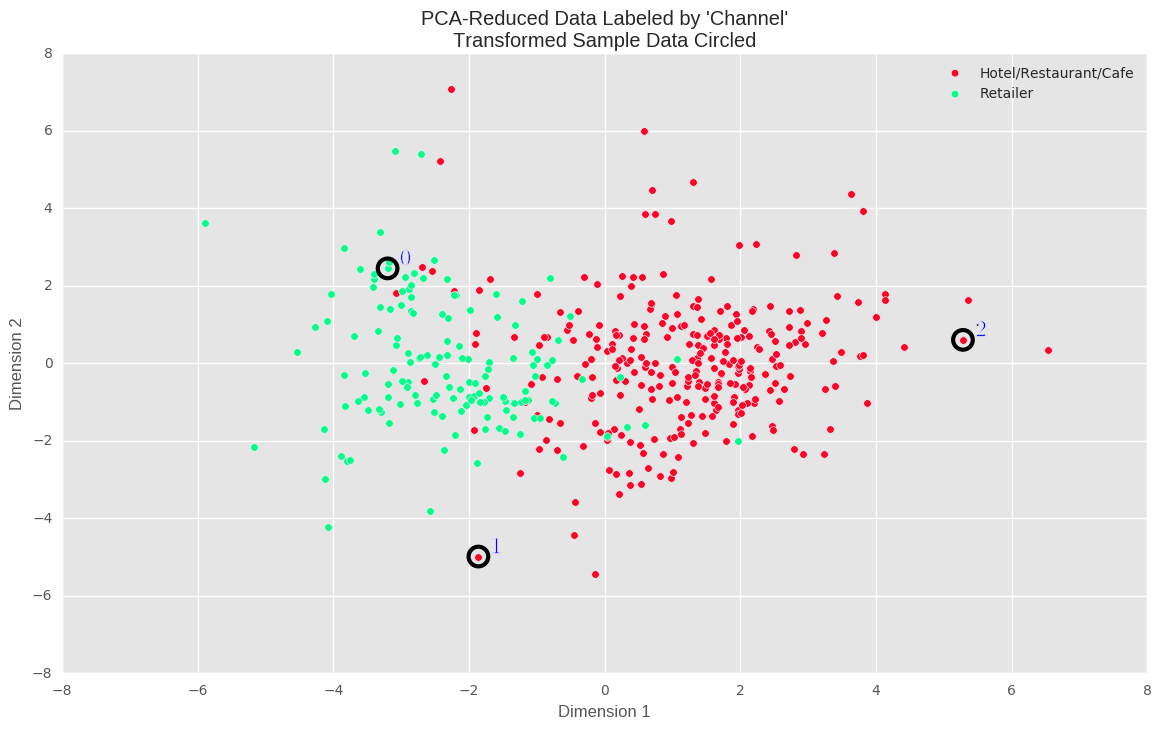

In [86]:
# The outliers that were removed
outliers = removals

# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**  The underlying distribution had split the data into two categories. When visualised in two dimensions we can see that the region above aproximately 2 in `Dimension 1` is a region that is purely populated by *Hotels/Restaurants/Cafes*. Aproximately below -3.5 in the same dimension is the region populated purely by Retailers. The region in between contains a fair bit of overlap between these two categories, but it is clear that the region above -0.5 in `Dimension 1` is populated predominantly by *Hotels/Restaurants/Cafes*, and values below that are predominantly populated by *Retailers*. 

The clustering algorithm comes quite close to splitting the data into these two categories correctly, but given the amount of overlap that exists in the data it is reasonable to expect some amount of error. The clustering algorithm correctly clustered two of the sample data points to different groups, but for point 1, it incorrectly labelled it as belonging to the *Retailers* cluster when in fact it belonged to the *Hotels/Restaurants/Cafes* cluster. But this was a dificult data point to classify correctly anyway as it lay within that region of overlap.